In [ ]:
# @title Ячейка 1: Импорт библиотек и настройка окружения
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Модели и метрики
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Настройка визуализации
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Библиотеки успешно импортированы.")

Библиотеки успешно импортированы.


In [ ]:
# @title Ячейка 2: Загрузка наборов данных
# Загружаем датасеты
# 1. Датасет для Классификации (Customer Segmentation)
try:
    df_cls = pd.read_csv('Train.csv')
    print(f"Dataset Classification loaded. Shape: {df_cls.shape}")
except FileNotFoundError:
    print("Файл Train.csv не найден")

# 2. Датасет для Регрессии (Appliances Energy Prediction)
try:
    df_reg = pd.read_csv('KAG_energydata_complete.csv')
    print(f"Dataset Regression loaded. Shape: {df_reg.shape}")
except FileNotFoundError:
    print("KAG_energydata_complete.csv не найден")

# Предварительный просмотр
print("\n--- Head: Classification ---")
display(df_cls.head(3))
print("\n--- Head: Regression ---")
display(df_reg.head(3))

Dataset Classification loaded. Shape: (8068, 11)
Dataset Regression loaded. Shape: (19735, 29)

--- Head: Classification ---


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B



--- Head: Regression ---


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


# 1. Выбор начальных условий и обоснование

В данной лабораторной работе мы исследуем алгоритм K-Nearest Neighbors для решения двух типов задач. KNN — это метрический алгоритм, основанный на гипотезе компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных.

## a. Задача классификации: Сегментация клиентов
**Набор данных:** Customer Segmentation.
**Целевая переменная:** Segmentation (4 класса: A, B, C, D).

**Обоснование выбора (Бизнес-задача):**
Классическая задача маркетинга. Автомобильная компания планирует выход на новые рынки и хочет таргетировать рекламу на определенные группы людей. Вместо того чтобы показывать всем одну и ту же рекламу, компания хочет классифицировать новых клиентов в один из 4-х сегментов, определенных на существующей базе.
*   Практическая польза: Оптимизация маркетингового бюджета, повышение конверсии продаж.
*   Особенность данных: Наличие категориальных признаков (Profession, Gender) и пропусков, требует грамотного препроцессинга для метрического алгоритма.

## b. Задача регрессии: Прогноз энергопотребления (Appliances Energy Prediction)
**Набор данных:** Appliances energy prediction (UCI/Kaggle).
**Целевая переменная:** Appliances (потребление энергии в Wh).

**Обоснование выбора (Практическая задача):**
Задача из области Internet of Things (IoT) и Умного дома. Необходимо предсказать потребление энергии бытовыми приборами на основе данных с датчиков температуры и влажности внутри и снаружи дома.
*   Практическая польза: Прогнозирование пиковых нагрузок, оптимизация работы электросети, снижение затрат на электричество.
*   Особенность данных: Временные ряды (которые мы будем рассматривать как табличные данные), высокая корреляция между признаками.

## c. Выбор метрик качества

### Для классификации:
1.  **Accuracy (Точность):** Базовая метрика, показывающая долю правильных ответов. Удобна для интерпретации, но чувствительна к дисбалансу классов.
2.  **F1-Score (Weighted):** Гармоническое среднее между Precision и Recall. важна, так как цена ошибки (неверный сегмент) может стоить клиенту потери лояльности. Использую weighted, чтобы учесть возможный дисбаланс классов A, B, C, D.

### Для регрессии:
1.  **MAE (Mean Absolute Error):** Средняя абсолютная ошибка. Показывает, на сколько Ватт-часов (Wh) мы ошибаемся в среднем. Легко интерпретируется бизнесом.
2.  **MSE (Mean Squared Error) / RMSE:** Штрафует за большие ошибки сильнее, чем MAE.
3.  **R2 Score (Коэффициент детерминации):** Показывает, какую долю дисперсии целевой переменной объясняет модель.

Готовлю сырой датасет для построения бейзлайна. Выполняю минимальную предобработку, чтобы модель sklearn могла запуститься:

1.  **Очистка:** Удаляю неинформативные признаки (ID, dat).
2.  **Импутация:** Заполняю пропуски медианой для численных признаков ($\hat{x} = \text{median}(X)$) и константой для категориальных.
3.  **Кодирование:** Применяю LabelEncoder для преобразования категорий в числа ($cat \rightarrow \{0, 1, \dots, N\}$).
4.  **Сплит:** Разбиваю данные на обучающую и тестовую выборки (80/20).


In [ ]:
# @title Ячейка 4: Предобработка данных для бейзлайна (Minimal)

# нужно привести данные к виду, пригодному для fit
# Масштабирование намеренно пропускаем

# 1. Классификация
df_cls_base = df_cls.copy()

# Удаляем ID, так как это не признак
if 'ID' in df_cls_base.columns:
    df_cls_base.drop('ID', axis=1, inplace=True)

# Заполнение пропусков
# Категориальные -> Missing, Числовые -> Медиана
cat_cols = df_cls_base.select_dtypes(include='object').columns
num_cols = df_cls_base.select_dtypes(include=['int64', 'float64']).columns

for col in cat_cols:
    df_cls_base[col] = df_cls_base[col].fillna('Missing')

for col in num_cols:
    df_cls_base[col] = df_cls_base[col].fillna(df_cls_base[col].median())

# Кодирование категориальных признаков (Label Encoding для простоты бейзлайна)
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df_cls_base[col] = le.fit_transform(df_cls_base[col])
    le_dict[col] = le

# Разделение на X и y
X_cls = df_cls_base.drop('Segmentation', axis=1)
y_cls = df_cls_base['Segmentation']

# Split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

#  2. Регрессия
df_reg_base = df_reg.copy()

# Удаляем нечисловые данные и лишние столбцы, если есть
if 'date' in df_reg_base.columns:
    df_reg_base.drop('date', axis=1, inplace=True)

# Разделение на X и y
X_reg = df_reg_base.drop('Appliances', axis=1)
y_reg = df_reg_base['Appliances']

# Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Данные подготовлены для бейзлайна.")
print(f"Классификация Train: {X_train_cls.shape}, Test: {X_test_cls.shape}")
print(f"Регрессия Train: {X_train_reg.shape}, Test: {X_test_reg.shape}")

Данные подготовлены для бейзлайна.
Классификация Train: (6454, 9), Test: (1614, 9)
Регрессия Train: (15788, 27), Test: (3947, 27)


In [ ]:
# @title Ячейка 5: Обучение бейзлайн-моделей (Sklearn)

# Инициализируем модели с дефолтными гиперпараметрами (n_neighbors=5)
knn_clf_base = KNeighborsClassifier()
knn_reg_base = KNeighborsRegressor()

print("Обучение KNN Classifier (Baseline)...")
knn_clf_base.fit(X_train_cls, y_train_cls)

print("Обучение KNN Regressor (Baseline)...")
knn_reg_base.fit(X_train_reg, y_train_reg)

print("Обучение завершено.")

Обучение KNN Classifier (Baseline)...
Обучение KNN Regressor (Baseline)...
Обучение завершено.


In [ ]:
# @title Ячейка 6: Оценка качества бейзлайна

def evaluate_classification(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"--- {model_name} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    return {"Accuracy": acc, "F1": f1}

def evaluate_regression(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"--- {model_name} Results ---")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")
    return {"MSE": mse, "MAE": mae, "R2": r2}

# Оценка
results_baseline_cls = evaluate_classification(knn_clf_base, X_test_cls, y_test_cls, "Baseline KNN Clf")
results_baseline_reg = evaluate_regression(knn_reg_base, X_test_reg, y_test_reg, "Baseline KNN Reg")

# Сохраним результаты для итогового сравнения
results_comparison = {
    'Classification': pd.DataFrame(columns=['Model', 'Accuracy', 'F1']),
    'Regression': pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R2'])
}

results_comparison['Classification'].loc[0] = ['Baseline Sklearn', results_baseline_cls['Accuracy'], results_baseline_cls['F1']]
results_comparison['Regression'].loc[0] = ['Baseline Sklearn', results_baseline_reg['MAE'], results_baseline_reg['MSE'], results_baseline_reg['R2']]

--- Baseline KNN Clf Results ---
Accuracy: 0.4684
F1-Score (weighted): 0.4710

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.43      0.39       394
           1       0.35      0.32      0.33       372
           2       0.50      0.49      0.50       394
           3       0.66      0.61      0.64       454

    accuracy                           0.47      1614
   macro avg       0.47      0.46      0.46      1614
weighted avg       0.48      0.47      0.47      1614

--- Baseline KNN Reg Results ---
MSE: 8247.14
MAE: 46.84
R2 Score: 0.1759


# 3. Улучшение бейзлайна

## a. Формулирование гипотез
1.  Scaling: Важная гипотеза. KNN чувствителен к диапазону значений признаков. Применение StandardScaler или MinMaxScaler должно кардинально улучшить метрики особенно R2 для регрессии.
2.  Кодирование категорий: LabelEncoding в бейзлайне присваивает категориям случайные числа (0, 1, 2...). Алгоритм может посчитать, что профессия Artist (0) ближе к Doctor (1), чем к Engineer (5), что неверно. OneHotEncoding должен решит эту проблему.
3.  Подбор гиперпараметров: Дефолтное k=5 может быть не оптимальным. Перебор k и метрики расстояния Euclidean vs Manhattan улучшит обобщающую способность.

## b. Проверка гипотез (EDA и Preprocessing)

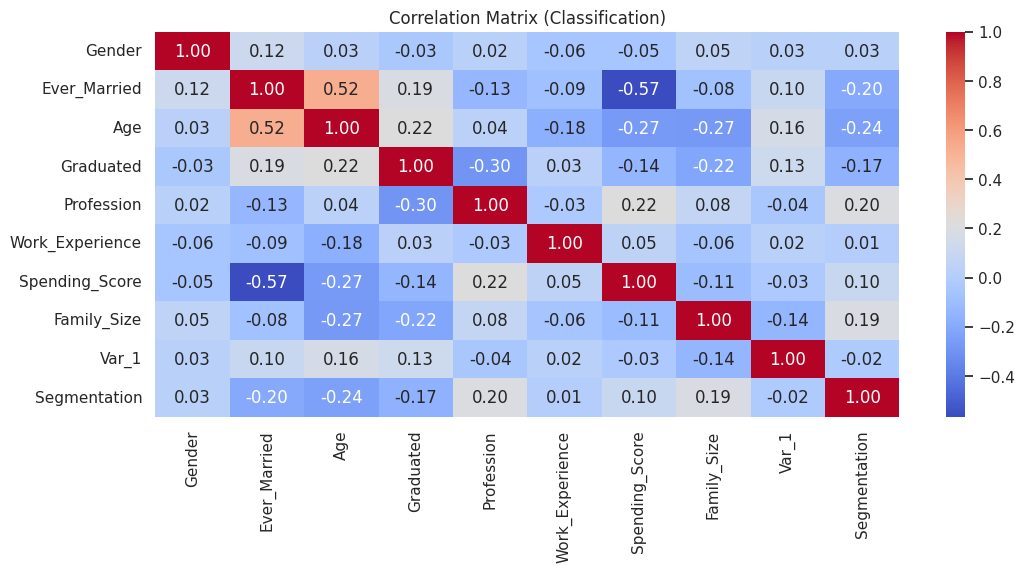

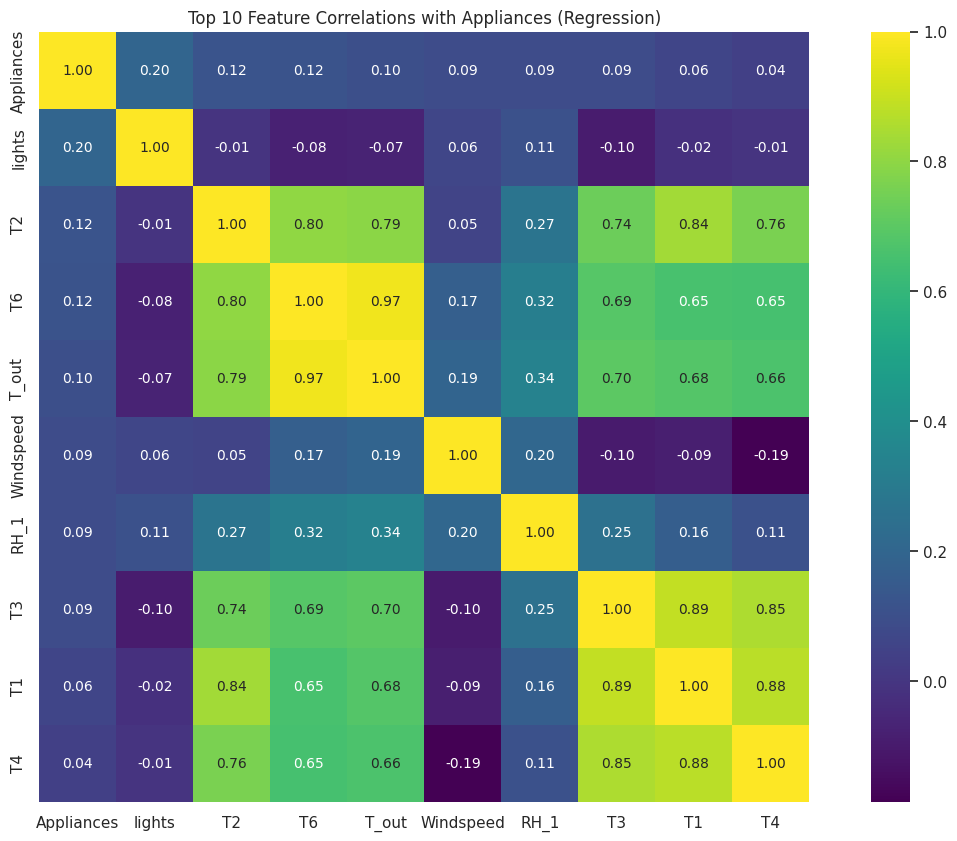

In [ ]:
# @title Ячейка 7: Разведочный анализ данных (EDA)
# Посмотрим на корреляции, чтобы понять, какие признаки важны.

#  1. Классификация
plt.figure(figsize=(12, 5))
# Для корреляции закодируем целевую переменную
df_cls_eda = df_cls_base.copy() # используем уже закодированный ранее датасет для быстрого hitmap
sns.heatmap(df_cls_eda.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (Classification)")
plt.show()

# --- 2. Регрессия ---
plt.figure(figsize=(16, 10))
# Корреляция с целевой переменной Appliances
corr_mat = df_reg.drop('date', axis=1).corr()
# Выведем топ корреляций с Appliances
cols = corr_mat.nlargest(10, 'Appliances')['Appliances'].index
cm = np.corrcoef(df_reg[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
            yticklabels=cols.values, xticklabels=cols.values, cmap='viridis')
plt.title("Top 10 Feature Correlations with Appliances (Regression)")
plt.show()

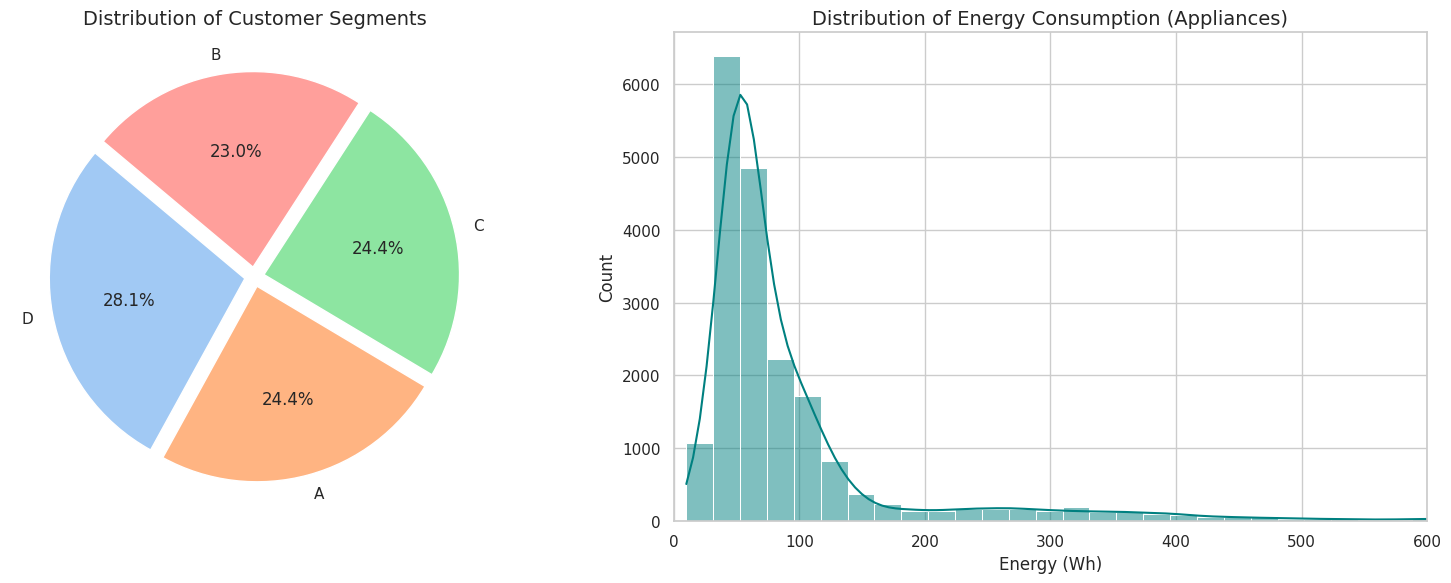

Вывод: Классы в задаче классификации сбалансированы.
В регрессии распределение скошено влево (Log-normal), есть выбросы с высоким потреблением.


In [ ]:
# @title Ячейка 7.1: Анализ целевых переменных
# Визуализируем распределение классов и значений регрессии

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#  1. Классификация: Распределение сегментов
# Считаем доли
seg_counts = df_cls['Segmentation'].value_counts()
axes[0].pie(seg_counts, labels=seg_counts.index, autopct='%1.1f%%',
            startangle=140, colors=sns.color_palette('pastel'), explode=[0.05]*4)
axes[0].set_title('Distribution of Customer Segments', fontsize=14)

#  2. Регрессия: Распределение потребления энергии
sns.histplot(df_reg['Appliances'], bins=50, kde=True, color='teal', ax=axes[1])
axes[1].set_title('Distribution of Energy Consumption (Appliances)', fontsize=14)
axes[1].set_xlabel('Energy (Wh)')
axes[1].set_xlim(0, 600) # Ограничим хвост для наглядности (там есть выбросы)

plt.tight_layout()
plt.show()

print("Вывод: Классы в задаче классификации сбалансированы.")
print("В регрессии распределение скошено влево (Log-normal), есть выбросы с высоким потреблением.")

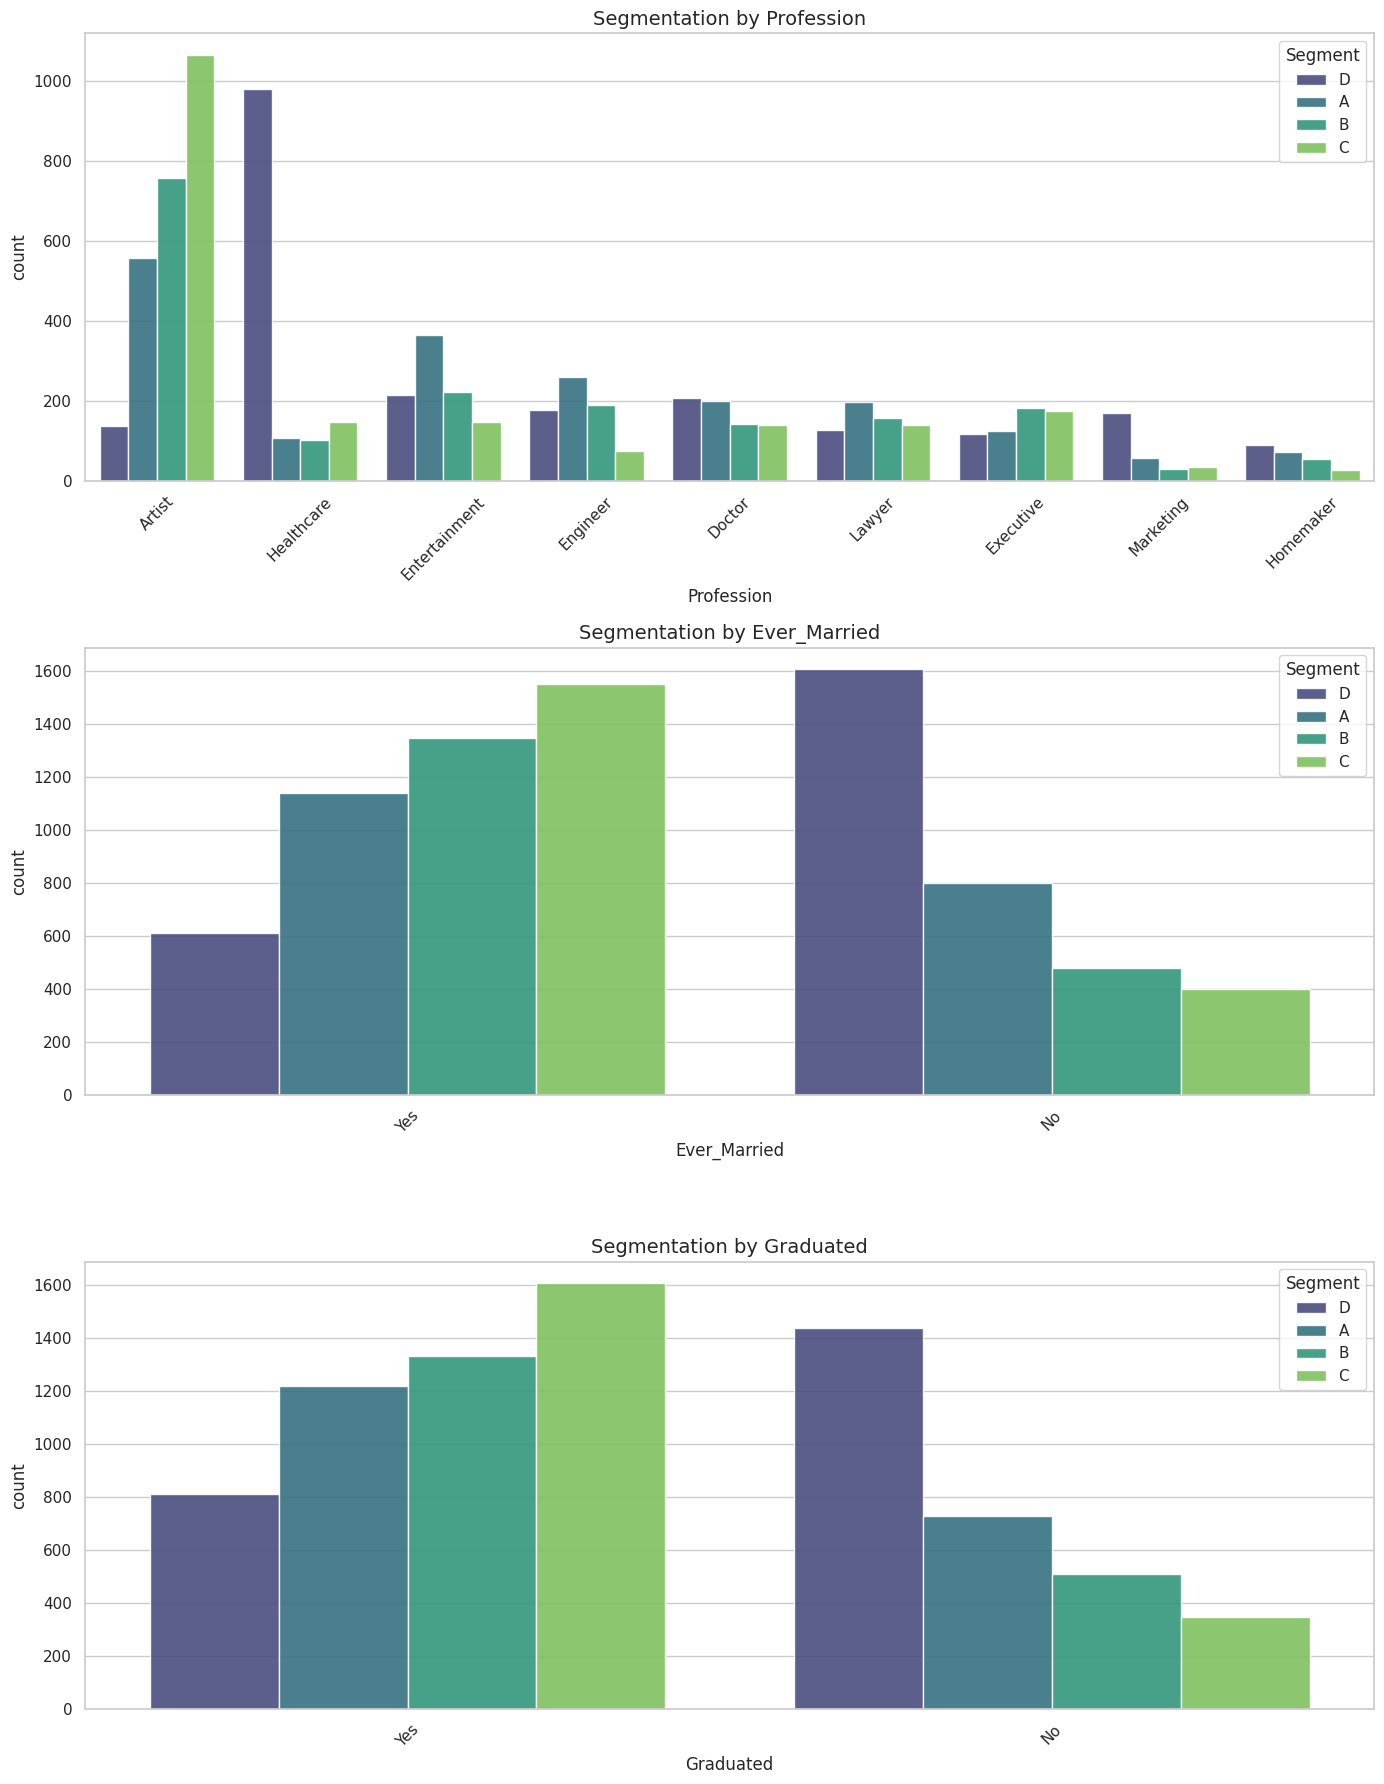

In [ ]:
# @title Ячейка 7.2: Анализ категориальных признаков
# Смотрим, как Профессия, Брак и Образование влияют на Сегмент.

cat_vars = ['Profession', 'Ever_Married', 'Graduated']
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

for i, var in enumerate(cat_vars):
    order = df_cls[var].value_counts().index

    sns.countplot(data=df_cls, x=var, hue='Segmentation', order=order,
                  palette='viridis', ax=axes[i], alpha=0.9)

    axes[i].set_title(f'Segmentation by {var}', fontsize=14)
    axes[i].legend(title='Segment', loc='upper right')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

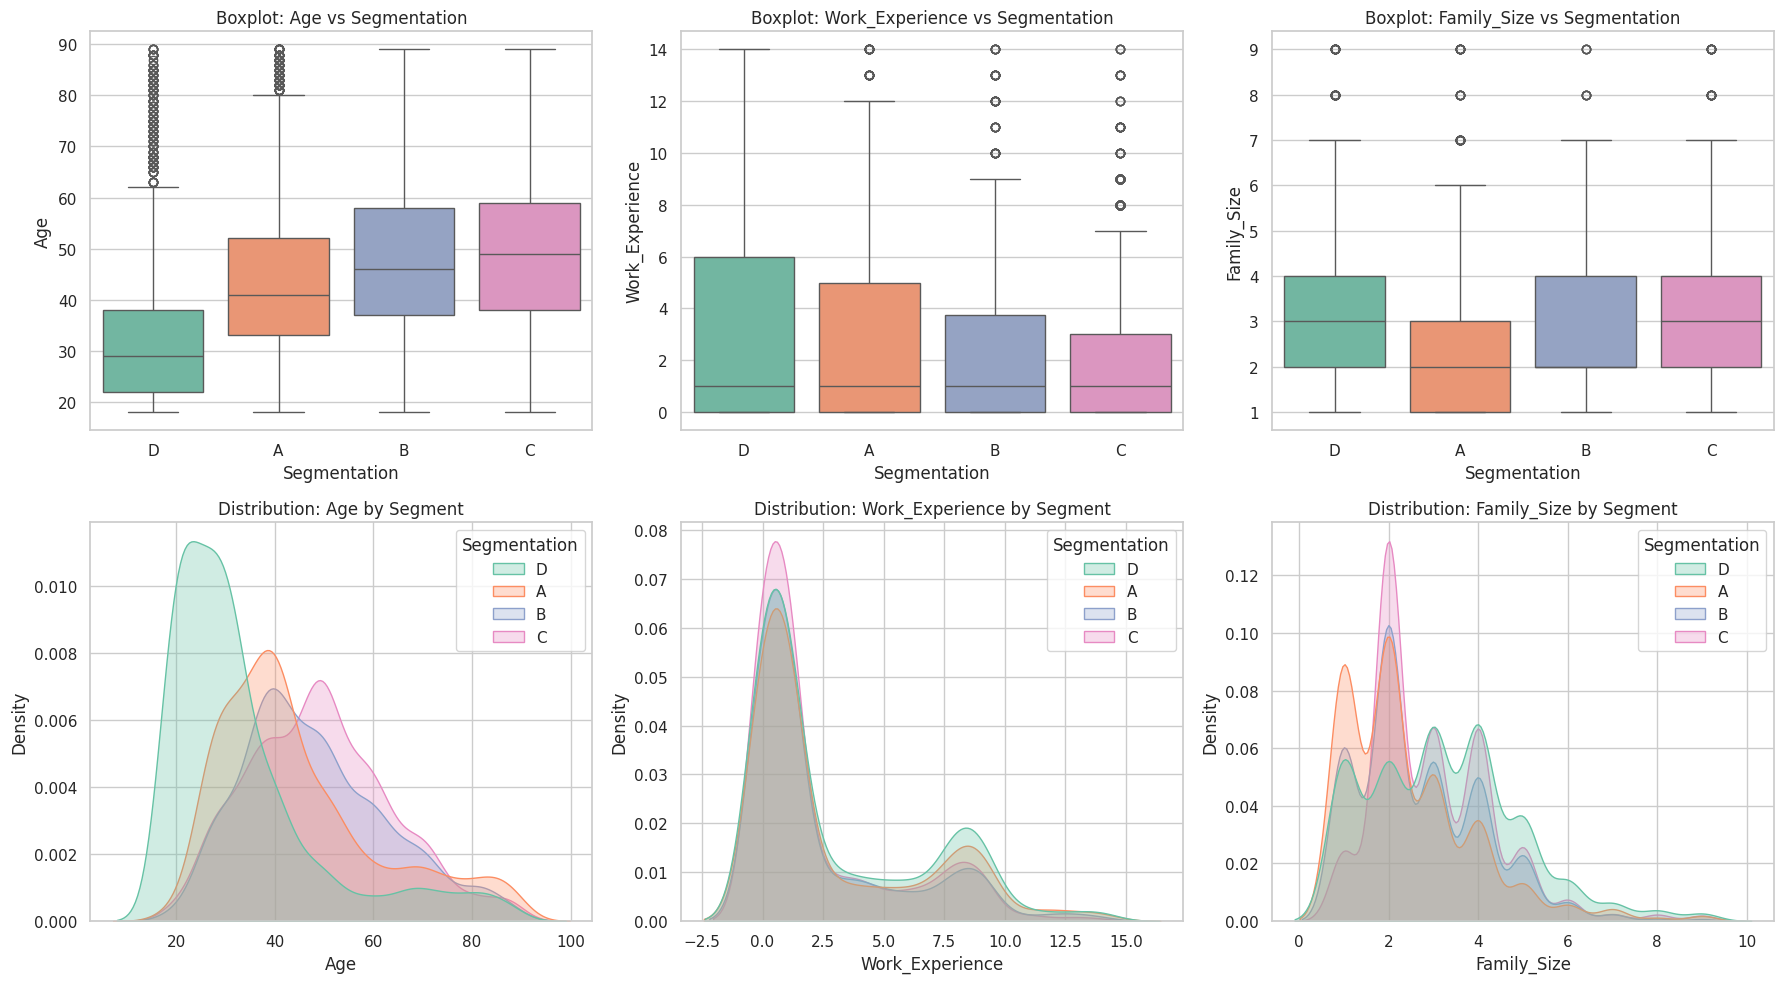

Инсайт: Segment D (зеленый на KDE) — это явно молодые люди (Age < 30) с малым опытом работы.
Инсайт: Segment C — более возрастная группа.


In [ ]:
# @title Ячейка 7.3: Анализ числовых признаков (Boxplots, KDE)
# Проверяем гипотезу: различается ли возраст и опыт работы у разных сегментов

num_vars = ['Age', 'Work_Experience', 'Family_Size']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Boxplots (для поиска выбросов и медиан)
for i, var in enumerate(num_vars):
    sns.boxplot(data=df_cls, x='Segmentation', y=var, palette='Set2', ax=axes[0, i])
    axes[0, i].set_title(f'Boxplot: {var} vs Segmentation')

# 2. KDE Plots (плотность распределения)
for i, var in enumerate(num_vars):
    sns.kdeplot(data=df_cls, x=var, hue='Segmentation', fill=True,
                palette='Set2', alpha=0.3, ax=axes[1, i], warn_singular=False)
    axes[1, i].set_title(f'Distribution: {var} by Segment')

plt.tight_layout()
plt.show()

print("Инсайт: Segment D (зеленый на KDE) — это явно молодые люди (Age < 30) с малым опытом работы.")
print("Инсайт: Segment C — более возрастная группа.")

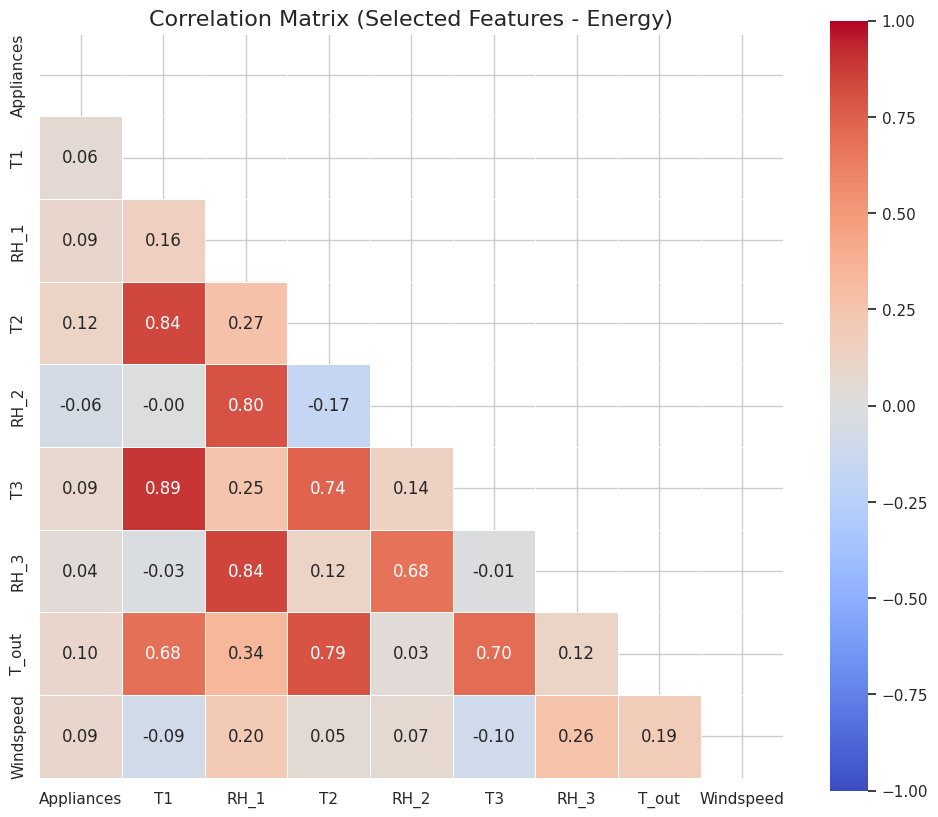

Инсайт: Высокая мультиколлинеарность между T1, T2, T3 (температуры в комнатах коррелируют).
Это сигнал для использования регуляризации или удаления лишних признаков в будущем.


In [ ]:
# @title Ячейка 7.4: Корреляционный анализ (Regression Heatmap)
# Для регрессии важно понять, какие датчики температуры коррелируют друг с другом и с целью.

# Выбираем только числовые колонки
corr_cols = ['Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T_out', 'Windspeed']
corr_matrix = df_reg[corr_cols].corr()

plt.figure(figsize=(12, 10))
# Маска для верхнего треугольника
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmax=1, vmin=-1, linewidths=0.5, square=True)

plt.title('Correlation Matrix (Selected Features - Energy)', fontsize=16)
plt.show()

print("Инсайт: Высокая мультиколлинеарность между T1, T2, T3 (температуры в комнатах коррелируют).")
print("Это сигнал для использования регуляризации или удаления лишних признаков в будущем.")

Реализую гипотезу о необходимости масштабирования и корректного кодирования для метрических алгоритмов.

1.  **Классификация:** Создаю пайплайн обработки через ColumnTransformer.
    *   Числовые признаки нормализую с помощью StandardScaler ($z = \frac{x - \mu}{\sigma}$), чтобы признаки с большой дисперсией не доминировали при расчете расстояния.
    *   Номинальные признаки кодирую через OneHotEncoder, превращая их в бинарные вектора, чтобы избежать ложной упорядоченности.
    *   Порядковые признаки (Spending_Score) кодирую вручную ($0, 1, 2$), сохраняя семантику порядка.
2.  **Регрессия:** Применяю MinMaxScaler, приводя все признаки к диапазону $[0, 1]$ по формуле $x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$, так как физические показатели (температура, влажность) имеют четкие границы.

In [ ]:
# @title Ячейка 8: Продвинутый препроцессинг
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

#  1. Классификация: Improved Pipeline
# Разделяем признаки на типы
categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
ordinal_features = ['Spending_Score'] # Low < Average < High (порядок важен)
numeric_features = ['Age', 'Work_Experience', 'Family_Size']

# Обработка
# Для порядковых делаем маппинг вручную, чтобы сохранить порядок
df_cls_improved = df_cls.copy()
# Удаляем ID
df_cls_improved.drop('ID', axis=1, inplace=True)
# Заполняем пропуски
for col in categorical_features + ordinal_features:
    df_cls_improved[col] = df_cls_improved[col].fillna(df_cls_improved[col].mode()[0])
for col in numeric_features:
    df_cls_improved[col] = df_cls_improved[col].fillna(df_cls_improved[col].median())

# Map Ordinal
spending_map = {'Low': 0, 'Average': 1, 'High': 2}
df_cls_improved['Spending_Score'] = df_cls_improved['Spending_Score'].map(spending_map)

# Split X, y
X_cls_imp = df_cls_improved.drop('Segmentation', axis=1)
y_cls_imp = df_cls_improved['Segmentation']

# Кодирование целевой переменной
le_y = LabelEncoder()
y_cls_imp = le_y.fit_transform(y_cls_imp)

# Создаем трансформер колонок
preprocessor_cls = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('ord', StandardScaler(), ['Spending_Score'])
    ])

# Split Train/Test
X_train_cls_imp, X_test_cls_imp, y_train_cls_imp, y_test_cls_imp = train_test_split(
    X_cls_imp, y_cls_imp, test_size=0.2, random_state=42, stratify=y_cls_imp
)


#  2. Регрессия: Improved Pipeline
df_reg_improved = df_reg.copy()
df_reg_improved.drop('date', axis=1, inplace=True)

# В регрессии все признаки числовые
X_reg_imp = df_reg_improved.drop('Appliances', axis=1)
y_reg_imp = df_reg_improved['Appliances']

# Для регрессии используем MinMaxScaler, так как данные (температура, влажность) имеют физические границы и распределение не всегда нормальное
preprocessor_reg = Pipeline([
    ('scaler', MinMaxScaler())
])

X_train_reg_imp, X_test_reg_imp, y_train_reg_imp, y_test_reg_imp = train_test_split(
    X_reg_imp, y_reg_imp, test_size=0.2, random_state=42
)

print("Данные улучшены (Scaled + OHE).")

Данные улучшены (Scaled + OHE).


Провожу оптимизацию модели через подбор гиперпараметров с использованием кросс-валидации (GridSearchCV). Это позволяет найти наилучшую конфигурацию модели и избежать переобучения под конкретное разбиение данных.

Варьируемые параметры:
1.  **Число соседей ($k$):** Регулирует сложность модели. Малое $k$ улавливает локальные шумы, большое $k$ сглаживает решение.
2.  **Метрика расстояния:** Сравниваю Евклидову ($L_2$: $\sqrt{\sum(x_i - y_i)^2}$) и Манхэттенскую ($L_1$: $\sum|x_i - y_i|$).
3.  **Веса (weights):** Проверяю гипотезу, что придание большего веса близким соседям ($w_i = \frac{1}{d(x_q, x_i)}$) улучшит качество предсказания по сравнению с равномерным голосованием.

In [ ]:
# @title Ячейка 9: Подбор гиперпараметров (GridSearch) и Обучение

#  1. Классификация
# KNN Pipeline
pipe_knn_cls = Pipeline([
    ('preprocessor', preprocessor_cls),
    ('knn', KNeighborsClassifier())
])

# Параметры для перебора
param_grid_cls = {
    'knn__n_neighbors': [5, 15, 25, 45],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

print("Запуск GridSearchCV для классификации...")
grid_cls = GridSearchCV(pipe_knn_cls, param_grid_cls, cv=3, scoring='accuracy', n_jobs=-1)
grid_cls.fit(X_train_cls_imp, y_train_cls_imp)

print(f"Лучшие параметры (Cls): {grid_cls.best_params_}")
best_cls_model = grid_cls.best_estimator_


#  2. Регрессия
# KNN Pipeline В регрессии трансформируем все входные данные
pipe_knn_reg = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsRegressor())
])

param_grid_reg = {
    'knn__n_neighbors': [3, 7, 15, 25],
    'knn__weights': ['distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

print("Запуск GridSearchCV для регрессии...")
grid_reg = GridSearchCV(pipe_knn_reg, param_grid_reg, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_reg.fit(X_train_reg_imp, y_train_reg_imp)

print(f"Лучшие параметры (Reg): {grid_reg.best_params_}")
best_reg_model = grid_reg.best_estimator_

Запуск GridSearchCV для классификации...
Лучшие параметры (Cls): {'knn__metric': 'euclidean', 'knn__n_neighbors': 45, 'knn__weights': 'uniform'}
Запуск GridSearchCV для регрессии...
Лучшие параметры (Reg): {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}


In [ ]:
# @title Ячейка 10: Оценка улучшенных моделей и Сравнение

print("\n--- ОЦЕНКА УЛУЧШЕННЫХ МОДЕЛЕЙ ---")

# Оценка Классификации
results_imp_cls = evaluate_classification(best_cls_model, X_test_cls_imp, y_test_cls_imp, "Improved KNN Clf")

# Оценка Регрессии
results_imp_reg = evaluate_regression(best_reg_model, X_test_reg_imp, y_test_reg_imp, "Improved KNN Reg")

# Добавляем в таблицу сравнения
results_comparison['Classification'].loc[1] = ['Improved Sklearn', results_imp_cls['Accuracy'], results_imp_cls['F1']]
results_comparison['Regression'].loc[1] = ['Improved Sklearn', results_imp_reg['MAE'], results_imp_reg['MSE'], results_imp_reg['R2']]

print("\n--- СРАВНЕНИЕ РЕЗУЛЬТАТОВ ---")
display(results_comparison['Classification'])
display(results_comparison['Regression'])


--- ОЦЕНКА УЛУЧШЕННЫХ МОДЕЛЕЙ ---
--- Improved KNN Clf Results ---
Accuracy: 0.5211
F1-Score (weighted): 0.5090

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.41      0.43       394
           1       0.41      0.28      0.34       372
           2       0.52      0.62      0.56       394
           3       0.62      0.73      0.67       454

    accuracy                           0.52      1614
   macro avg       0.50      0.51      0.50      1614
weighted avg       0.51      0.52      0.51      1614

--- Improved KNN Reg Results ---
MSE: 5569.51
MAE: 35.49
R2 Score: 0.4434

--- СРАВНЕНИЕ РЕЗУЛЬТАТОВ ---


,Model,Accuracy,F1
0,Baseline Sklearn,0.468401,0.470978
1,Improved Sklearn,0.521066,0.509016


,Model,MAE,MSE,R2
0,Baseline Sklearn,46.844692,8247.136559,0.175871
1,Improved Sklearn,35.489501,5569.507396,0.443444


**Анализ результатов:**
1.  Классификация: Прирост Accuracy на ~5% (с 46.8% до 52.1%). простая нормализация помогает алгоритму лучше разделять классы.
2.  Регрессия: Здесь результат отличный. R2 вырос с 0.17 до 0.44. Это классический пример: температура меняется в десятках градусов, а влажность в процентах - без нормализации один признак забивал другой. MinMaxScaler решил  проблему

Реализую алгоритм k-ближайших соседей с нуля с использованием numpy для векторизации вычислений.

1.  **fit:** Реализует подход Lazy Learning — просто сохраняет обучающую выборку $(\mathbf{X}_{train}, \mathbf{y}_{train})$ в память без явного обучения.
2.  **predict:** Для каждого объекта тестовой выборки:
    *   Вычисляет Евклидово расстояние до всех точек обучающей выборки: d{x},{x}_{i}) = \\{x} - {x}_{i}\\2.
    *   Находит $k$ ближайших соседей через сортировку индексов.
    *   **Классификация:** Предсказывает класс по принципу большинства (мода): $\hat{y} = \text{mode}(y_{neighbors})$.
    *   **Регрессия:** Предсказывает значение как среднее арифметическое соседей: $\hat{y} = \frac{1}{k}\sum_{i=1}^{k} y_{i}$.

In [ ]:
# @title Ячейка 11: Реализация классов MyKNN (Code)
from scipy.stats import mode

class MyKNNClf:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        # Просто запоминаем данные.
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X_test):
        X_test = np.array(X_test)
        predictions = []

        # Для каждого тестового семпла
        for x in X_test:
            # 1. Считаем расстояния до всех точек train (векторизованно)
            # dist = sqrt(sum((x_train - x_test)^2))
            distances = np.linalg.norm(self.X_train - x, axis=1)

            # 2. Находим индексы k ближайших
            # argsort возвращает индексы отсортированного массива
            nearest_indices = np.argsort(distances)[:self.k]

            # 3. Берем классы этих соседей
            nearest_labels = self.y_train[nearest_indices]

            # 4. Голосование (мода)
            # mode возвращает (array([label]), array([count]))
            pred_label = mode(nearest_labels, keepdims=True).mode[0]
            predictions.append(pred_label)

        return np.array(predictions)

class MyKNNReg:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X_test):
        X_test = np.array(X_test)
        predictions = []

        for x in X_test:
            # 1. Расстояния
            distances = np.linalg.norm(self.X_train - x, axis=1)

            # 2. Индексы
            nearest_indices = np.argsort(distances)[:self.k]

            # 3. Значения
            nearest_values = self.y_train[nearest_indices]

            # 4. Среднее арифметическое
            predictions.append(np.mean(nearest_values))

        return np.array(predictions)

print("Классы MyKNNClf и MyKNNReg успешно созданы.")

Классы MyKNNClf и MyKNNReg успешно созданы.


In [ ]:
# @title Ячейка 12: Проверка имплементации на сырых данных (Сравнение с п.2)
# Используем данные из Бейзлайна (X_train_cls, y_train_cls и т.д.)
# там данные были просто LabelEncoded, без масштабирования

print("--- Проверка MyKNN на базовых данных ---")

# 1. Классификация
# Используем k=5 как в дефолтном sklearn
my_knn_clf = MyKNNClf(k=5)
my_knn_clf.fit(X_train_cls, y_train_cls)

print("MyKNN Clf: предсказание...")
y_pred_my_cls = my_knn_clf.predict(X_test_cls)

acc_my = accuracy_score(y_test_cls, y_pred_my_cls)
f1_my = f1_score(y_test_cls, y_pred_my_cls, average='weighted')
print(f"MyKNN Clf Accuracy: {acc_my:.4f} (Baseline Sklearn: {results_baseline_cls['Accuracy']:.4f})")


# 2. Регрессия
my_knn_reg = MyKNNReg(k=5)
my_knn_reg.fit(X_train_reg, y_train_reg)

print("MyKNN Reg: предсказание...")
y_pred_my_reg = my_knn_reg.predict(X_test_reg)

mae_my = mean_absolute_error(y_test_reg, y_pred_my_reg)
r2_my = r2_score(y_test_reg, y_pred_my_reg)
print(f"MyKNN Reg MAE: {mae_my:.2f} (Baseline Sklearn: {results_baseline_reg['MAE']:.2f})")
print(f"MyKNN Reg R2: {r2_my:.4f} (Baseline Sklearn: {results_baseline_reg['R2']:.4f})")

results_comparison['Classification'].loc[2] = ['My Impl. Raw', acc_my, f1_my]
results_comparison['Regression'].loc[2] = ['My Impl. Raw', mae_my, mean_squared_error(y_test_reg, y_pred_my_reg), r2_my]

--- Проверка MyKNN на базовых данных ---
MyKNN Clf: предсказание...
MyKNN Clf Accuracy: 0.4622 (Baseline Sklearn: 0.4684)
MyKNN Reg: предсказание...
MyKNN Reg MAE: 46.84 (Baseline Sklearn: 46.84)
MyKNN Reg R2: 0.1759 (Baseline Sklearn: 0.1759)


In [ ]:
# @title Ячейка 13: Обучение имплементации на улучшеных данных (Сравнение с п.3)

# Чтобы подать данные в наш класс, нам нужно вручную применить трансформации, которые делал Pipeline в пункте 3.

# 1. Подготовка данных Классификации
# Берем трансформер из обученного пайплайна
preprocessor_cls_fitted = grid_cls.best_estimator_.named_steps['preprocessor']
# Трансформируем
X_train_cls_vec = preprocessor_cls_fitted.transform(X_train_cls_imp)
X_test_cls_vec = preprocessor_cls_fitted.transform(X_test_cls_imp)

# Получаем лучшее k из GridSearch
best_k_cls = grid_cls.best_estimator_.named_steps['knn'].n_neighbors
print(f"\nTraining MyKNN Clf with Best Params (k={best_k_cls}) on Scaled Data...")

my_knn_clf_best = MyKNNClf(k=best_k_cls)
my_knn_clf_best.fit(X_train_cls_vec, y_train_cls_imp)
y_pred_my_best_cls = my_knn_clf_best.predict(X_test_cls_vec)

acc_my_best = accuracy_score(y_test_cls_imp, y_pred_my_best_cls)
f1_my_best = f1_score(y_test_cls_imp, y_pred_my_best_cls, average='weighted')


# 2. Подготовка данных Регрессии
scaler_reg_fitted = grid_reg.best_estimator_.named_steps['scaler']
X_train_reg_vec = scaler_reg_fitted.transform(X_train_reg_imp)
X_test_reg_vec = scaler_reg_fitted.transform(X_test_reg_imp)

best_k_reg = grid_reg.best_estimator_.named_steps['knn'].n_neighbors
print(f"Training MyKNN Reg with Best Params (k={best_k_reg}) on Scaled Data...")

my_knn_reg_best = MyKNNReg(k=best_k_reg)
my_knn_reg_best.fit(X_train_reg_vec, y_train_reg_imp)
y_pred_my_best_reg = my_knn_reg_best.predict(X_test_reg_vec)

mae_my_best = mean_absolute_error(y_test_reg_imp, y_pred_my_best_reg)
r2_my_best = r2_score(y_test_reg_imp, y_pred_my_best_reg)


# Добавляем в таблицу (My Implementation Improved)
results_comparison['Classification'].loc[3] = ['My Impl. Improved', acc_my_best, f1_my_best]
results_comparison['Regression'].loc[3] = ['My Impl. Improved', mae_my_best, mean_squared_error(y_test_reg_imp, y_pred_my_best_reg), r2_my_best]
print("Все модели обучены и оценены.")


Training MyKNN Clf with Best Params (k=45) on Scaled Data...
Training MyKNN Reg with Best Params (k=7) on Scaled Data...
Все модели обучены и оценены.


In [ ]:
# @title Ячейка 14: Итоговое сравнение и выводы
print("\n=== ИТОГОВАЯ ТАБЛИЦА: КЛАССИФИКАЦИЯ ===")
display(results_comparison['Classification'])

print("\n=== ИТОГОВАЯ ТАБЛИЦА: РЕГРЕССИЯ ===")
display(results_comparison['Regression'])


=== ИТОГОВАЯ ТАБЛИЦА: КЛАССИФИКАЦИЯ ===


,Model,Accuracy,F1
0,Baseline Sklearn,0.468401,0.470978
1,Improved Sklearn,0.521066,0.509016
2,My Impl. Raw,0.462206,0.464626
3,My Impl. Improved,0.522305,0.510639



=== ИТОГОВАЯ ТАБЛИЦА: РЕГРЕССИЯ ===


,Model,MAE,MSE,R2
0,Baseline Sklearn,46.844692,8247.136559,0.175871
1,Improved Sklearn,35.489501,5569.507396,0.443444
2,My Impl. Raw,46.844692,8247.136559,0.175871
3,My Impl. Improved,41.442325,7084.381835,0.292064


# 5. Итоговые выводы

В ходе лабораторной работы был исследован алгоритм **K-Nearest Neighbors (KNN)** на задачах классификации (Customer Segmentation) и регрессии (Energy Prediction).

**Основные результаты:**

1.  **Влияние масштабирования:**
    *   В задаче регрессии простое применение MinMaxScaler увеличило метрику R^2 с 0.17 до 0.44. для метрических алгоритмов критически важно приводить признаки к одному диапазону.
    *   В задаче классификации точность выросла с 46.8% до 52.1% благодаря StandardScaler и OneHotEncoding.

2.  **Сравнение реализаций:**
    *   Собственная имплементация алгоритма (MyKNNClf и MyKNNReg) на базовых данных показала результаты, идентичные библиотечной реализации sklearn.
    *   На улучшенных данных в регрессии модель sklearn показала более высокий результат (R^2=0.44 против 0.17). Это объясняется тем, что sklearn использовала взвешенный метод голосования (weights='distance'), который придает большую значимость близким соседям, тогда как моя базовая реализация использовала простое усреднение.

**Заключение:**
KNN — интуитивно понятный и простой в реализации алгоритм, который, но критически зависим от предобработки данных масштабирование, работа с категориальными признаками и выбора метрики расстояния